# Stimulus Response Analyses

Analyze neuron responses to stimuli of interest.

#### Cells of interest 

THF-wv001-session_2:
- Neuron 51: maybe cares about full chests (non-specifically)

Other time points of interest:
- When the face is shown during recall

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path

from pynwb import NWBHDF5IO

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

from spiketools.plts.trials import plot_rasters
from spiketools.utils import restrict_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from utils import select_from_list
from analysis import calc_trial_frs

## Settings

In [5]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/')

In [6]:
# Define subject information
task = 'THF'
subj = 'wv001'
session = 2

In [7]:
# Set a unit of interest to select
uind = 7

In [8]:
# Set the time range to analyze
trial_range = [-1000, 1000]

## Load Data

In [9]:
# Define expected NWB file name & full path
file_name = '_'.join([task, subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [10]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [11]:
# Get the chest trial indices & stimuli information
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]

In [12]:
# Get times of chest opening
openings = nwbfile.trials.chest_opening_time[:]

In [13]:
# Check the number of chests
n_chests = len(openings)
print('Number of chests: {}'.format(n_chests))

Number of chests: 96


In [14]:
# Check the number of units & keep indices
n_units = len(nwbfile.units)
keep_inds = np.where(nwbfile.units.keep[:])[0]
n_keep = len(keep_inds)
print('Number of units: {}'.format(n_units))
print('Number to keep:  {}'.format(n_keep))

Number of units: 81
Number to keep:  57


In [15]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(uind)

## Chest Opening

In [16]:
# Gather neural data around trials of interest
all_trials = []
for opening in openings:
    time_range = restrict_range(spikes, opening + trial_range[0], opening + trial_range[1])
    all_trials.append(time_range - opening)

In [17]:
# Compute statistical test
t_val, p_val = ttest_rel(*calc_trial_frs(all_trials, average=False))

In [18]:
# Calculate firing rate pre & post chest opening
fr_pre, fr_post = calc_trial_frs(all_trials)

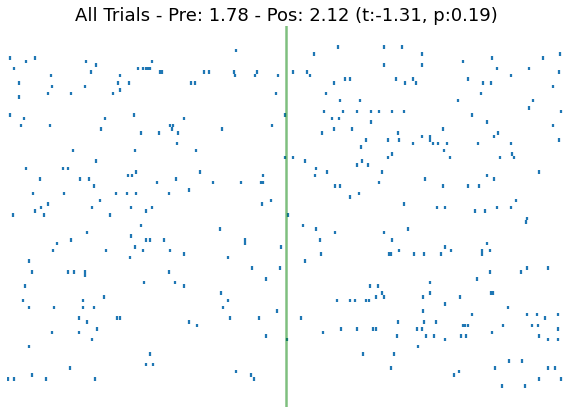

In [19]:
# Plot raster across 
plot_rasters(all_trials, xlim=trial_range, vline=0, figsize=(10, 7), 
             title='All Trials - Pre: {:1.2f} - Pos: {:1.2f} (t:{:1.2f}, p:{:1.2f})'.format(
                 fr_pre, fr_post, t_val, p_val))

## Stimuli

In [20]:
# Create masks to sub-select full & empty chests
full_mask = nwbfile.trials.full_chest.data[:]
empty_mask = np.invert(full_mask)

In [21]:
# Calculate how many full/empty chests there are
n_empty = sum(empty_mask)
n_full = sum(full_mask)

In [22]:
# Check how many full/empty chests there are
print('Number of empty chests: \t{}'.format(n_empty))
print('Number of full chests: \t\t{}'.format(n_full))

Number of empty chests: 	36
Number of full chests: 		60


In [23]:
# Sub-select full & empty chest trials
empty_trials = select_from_list(all_trials, empty_mask)
full_trials = select_from_list(all_trials, full_mask)

In [24]:
# Calculate firing rate pre & post chest opening
fr_pre_e, fr_post_e = calc_trial_frs(empty_trials)
fr_pre_f, fr_post_f = calc_trial_frs(full_trials)

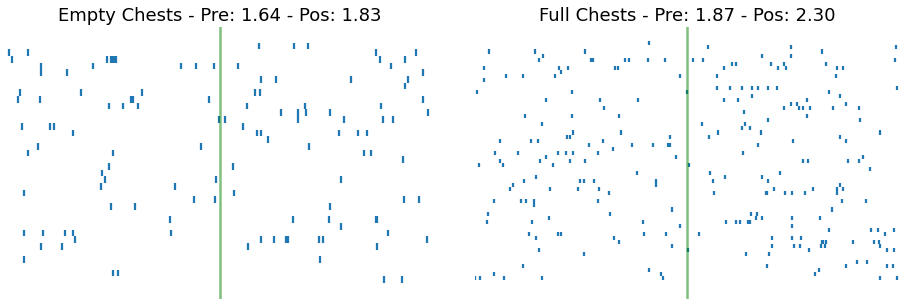

In [25]:
# Plot a comparison of full and empty trials
_, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_rasters(empty_trials, xlim=trial_range, vline=0, ax=axes[0], 
             title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_e, fr_post_e))
plot_rasters(full_trials, xlim=trial_range, vline=0, ax=axes[1],
             title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(fr_pre_f, fr_post_f))
plt.subplots_adjust(wspace=0.1)

### Check All Cells

In [26]:
# # Run across all cells
# for uind in keep_inds:

#     spikes = nwbfile.units.get_unit_spike_times(uind)
    
#     all_trials = []
#     for opening in openings:
#         time_range = restrict_range(spikes, opening + trial_range[0], opening + trial_range[1])
#         all_trials.append(time_range - opening)    
    
#     # Plot all trials together
#     #plot_rasters(all_trials, xlim=trial_range, figsize=(10, 7))

#     # Plot separate rasters for full and empty trials
#     _, axes = plt.subplots(1, 2, figsize=(16, 5))
#     empty_trials = select_from_list(all_trials, empty_mask)
#     plot_rasters(empty_trials, xlim=trial_range, vline=0,
#                  title='Empty Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(empty_trials)),
#                  ax=axes[0])
#     full_trials = select_from_list(all_trials, full_mask)
#     plot_rasters(full_trials, xlim=trial_range, vline=0,
#                  title='Full Chests - Pre: {:1.2f} - Pos: {:1.2f}'.format(*calc_trial_frs(full_trials)),
#                  ax=axes[1])
#     plt.subplots_adjust(wspace=0.1)
#     plt.suptitle('Neuron #{}'.format(uind))